In [ ]:
import pandas as pd
import catboost as cb
import plotly.express as px
from DataAnalysis import HelperFunctions as hf
from DataAnalysis import TweakedOvid
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
import shap

shap.initjs()

In [36]:
dataset_path = 'Dataset/'
random_state = 42
csdf = pd.read_csv(dataset_path + 'changeset_data.csv').set_index('cs_id')
udf = pd.read_csv(dataset_path + 'user_data.csv').set_index('cs_id')
# eldf = pd.read_csv(dataset_path + 'element_data.csv').set_index('cs_id')
labels = pd.read_csv(dataset_path + 'labels.csv').set_index('cs_id')

In [3]:
X, y = hf.get_prepped_csudf(dataset_path, to_numpy=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [6]:
# Following hyperparameters come from a GridSearchCV algorithm, with accuracy = 0.822
hyperparameters = {
    'hidden_layer_sizes': (1000, 1000),
    'alpha': 1e-05,
    'batch_size': 200,
    'learning_rate_init': 0.001,
    'max_iter': 400,
    'early_stopping': True,
    'validation_fraction': 0.125
}

mlp = MLPClassifier(**hyperparameters)
scaler = StandardScaler()
X_train_mlp = scaler.fit_transform(X_train)
print("pre fit")
mlp.fit(X_train_mlp, y_train.ravel())
print("post fit")

X_test_mlp = scaler.transform(X_test)
mlp_pred_test = mlp.predict(X_test_mlp)
mlp_pred_train = mlp.predict(X_train_mlp)

pre fit


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


post fit


######################## TRAINING DATA ###########################
              precision    recall  f1-score   support

       False       0.85      0.85      0.85     21493
        True       0.83      0.84      0.84     19967

    accuracy                           0.84     41460
   macro avg       0.84      0.84      0.84     41460
weighted avg       0.84      0.84      0.84     41460

########################## TEST DATA #############################
              precision    recall  f1-score   support

       False       0.83      0.82      0.83      5382
        True       0.81      0.81      0.81      4983

    accuracy                           0.82     10365
   macro avg       0.82      0.82      0.82     10365
weighted avg       0.82      0.82      0.82     10365



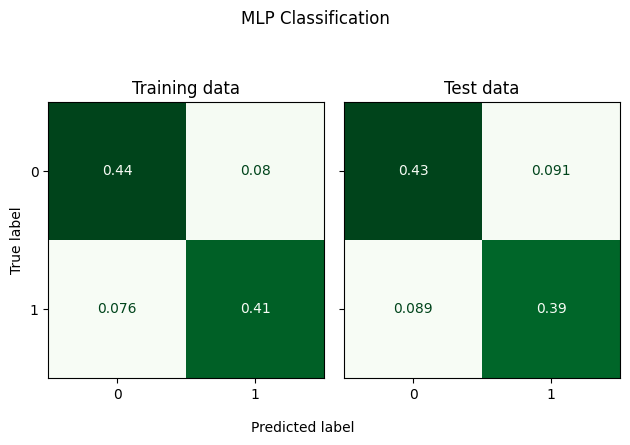

In [7]:
hf.print_report(mlp_pred_train, y_train, mlp_pred_test, y_test, title="MLP Classification")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig, ax = plt.subplots(1, 1, sharey='row')
ax.set_title('Training data')
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, mlp_pred_test, normalize='all'), display_labels=['Not Reverted', 'Reverted']).plot(ax=ax, cmap='Greens')
cmd.im_.colorbar.remove()
cmd.ax_.set_xlabel('Predicted label')
cmd.ax_.set_ylabel('True label')
ax.set_title('Test data for MLP')
plt.tight_layout()
plt.show()

In [ ]:
# explainer = shap.Explainer(mlp)
# shap_values = explainer(X_test)
#
# clust = shap.utils.hclust(X_test, y_test, linkage="single")
# shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

In [4]:
# The following hyperparameters come from a GridSearchCV.
hyperparameters = {
    'max_depth': 100,
    'max_features': 5,
    'n_estimators': 500
}
rfc_baseline = RandomForestClassifier(**hyperparameters)

rfc_baseline.fit(X_train, y_train.ravel())
rfc_baseline_pred_train = rfc_baseline.predict(X_train)
rfc_baseline_pred_test = rfc_baseline.predict(X_test)

######################## TRAINING DATA ###########################
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     21493
        True       1.00      1.00      1.00     19967

    accuracy                           1.00     41460
   macro avg       1.00      1.00      1.00     41460
weighted avg       1.00      1.00      1.00     41460

########################## TEST DATA #############################
              precision    recall  f1-score   support

       False       0.87      0.90      0.88      5382
        True       0.89      0.86      0.87      4983

    accuracy                           0.88     10365
   macro avg       0.88      0.88      0.88     10365
weighted avg       0.88      0.88      0.88     10365



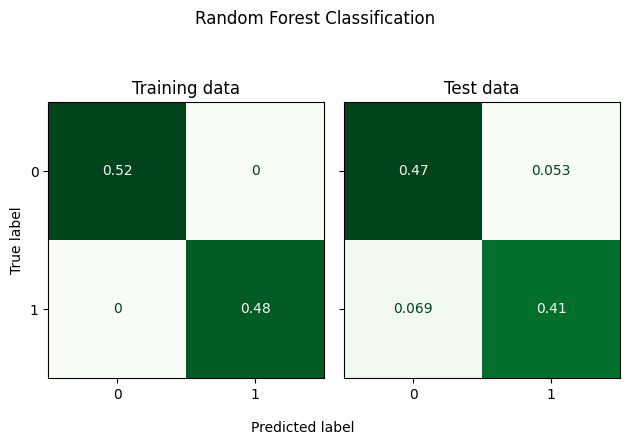

In [5]:
hf.print_report(rfc_baseline_pred_train, y_train, rfc_baseline_pred_test, y_test, title="Random Forest Classification")

In [ ]:
explainer = shap.TreeExplainer(rfc_baseline)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
hf.rfc_importances(X_test, y_test, rfc_baseline, cs=True, u=True, el=False)

In [8]:
X_cb, y_cb = hf.get_prepped_csudf(dataset_path)
X_cb.drop(columns=['go map!!', 'josm', 'osm go!', 'other', 'potlatch', 'streetcomplete', 'vespucci'], inplace=True)
X_cb = X_cb.join(csdf.loc[:, 'editor_app'])

X_cb.drop(columns=['nprev_changesets'], inplace=True)

X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, labels.replace(['True', 'False'], [True, False]), test_size=0.2, random_state=random_state)
X_train_cb, X_val_cb, y_train_cb, y_val_cb = train_test_split(X_train_cb, y_train_cb, test_size=0.25, random_state=random_state)

In [14]:
# detta var grid searchen som vi gjorde
# param_grid = {
#     'depth': [4, 7, 10],
#     'l2_leaf_reg': [0.5, 3, 10],
#     'learning_rate': [0.005, 0.03, 0.10]
# }

# detta var hyperparametrarna som kom ut:
hyperparameters_boosted_tree = {
    'depth': 7,
    'learning_rate': 0.1,
    'l2_leaf_reg': 0.5
}

cb_model = cb.CatBoostClassifier(iterations=750, **hyperparameters_boosted_tree, eval_metric='Accuracy')

In [15]:
cb_model.fit(X_train_cb, y_train_cb, early_stopping_rounds=250, eval_set=[(X_val_cb, y_val_cb)], plot=True, cat_features=['editor_app'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7199871	test: 0.7210806	best: 0.7210806 (0)	total: 23.1ms	remaining: 17.3s
1:	learn: 0.7423058	test: 0.7402798	best: 0.7402798 (1)	total: 44.4ms	remaining: 16.6s
2:	learn: 0.7598328	test: 0.7640135	best: 0.7640135 (2)	total: 64.8ms	remaining: 16.1s
3:	learn: 0.7663612	test: 0.7707670	best: 0.7707670 (3)	total: 86.5ms	remaining: 16.1s
4:	learn: 0.7687088	test: 0.7718283	best: 0.7718283 (4)	total: 107ms	remaining: 16s
5:	learn: 0.7778743	test: 0.7819585	best: 0.7819585 (5)	total: 129ms	remaining: 16s
6:	learn: 0.7792250	test: 0.7833092	best: 0.7833092 (6)	total: 150ms	remaining: 16s
7:	learn: 0.7806721	test: 0.7838881	best: 0.7838881 (7)	total: 174ms	remaining: 16.2s
8:	learn: 0.7847886	test: 0.7876507	best: 0.7876507 (8)	total: 196ms	remaining: 16.2s
9:	learn: 0.7872005	test: 0.7913169	best: 0.7913169 (9)	total: 217ms	remaining: 16s
10:	learn: 0.7910597	test: 0.7963338	best: 0.7963338 (10)	total: 239ms	remaining: 16s
11:	learn: 0.7922817	test: 0.7963338	best: 0.7963338 (10)	

In [16]:
cb_pred_train = cb_model.predict(X_train_cb) == 'True'
cb_pred_test = cb_model.predict(X_test_cb) == 'True'

######################## TRAINING DATA ###########################
              precision    recall  f1-score   support

       False       0.95      0.96      0.95     16097
        True       0.96      0.94      0.95     14998

    accuracy                           0.95     31095
   macro avg       0.95      0.95      0.95     31095
weighted avg       0.95      0.95      0.95     31095

########################## TEST DATA #############################
              precision    recall  f1-score   support

       False       0.86      0.89      0.87      5373
        True       0.87      0.85      0.86      4992

    accuracy                           0.87     10365
   macro avg       0.87      0.87      0.87     10365
weighted avg       0.87      0.87      0.87     10365



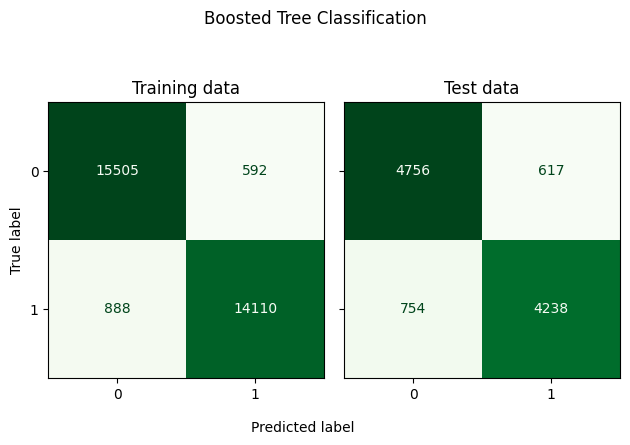

In [17]:
hf.print_report(cb_pred_train, y_train_cb, cb_pred_test, y_test_cb, title="Boosted Tree Classification", normalize=False)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig, ax = plt.subplots(1, 1, sharey='row')
ax.set_title('Training data')
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, cb_pred_test, normalize='all'), display_labels=['Not Reverted', 'Reverted']).plot(ax=ax, cmap='Greens')
cmd.im_.colorbar.remove()
cmd.ax_.set_xlabel('Predicted label')
cmd.ax_.set_ylabel('True label')
ax.set_title('Test data for Boosted Tree')
plt.tight_layout()
plt.show()

In [ ]:
shap.dependence_plot('nprev_changesets', shap_values, X_test, xmin="percentile(0.0)", xmax="percentile(95)", x_jitter=0.5, interaction_index=None)

In [ ]:
corr = udf['active_weeks'].corr(udf['nprev_changesets'])
print(f'Correlation between active_weeks and nprev_changesets: {corr}')
px.scatter(udf.join(labels), y='active_weeks', x='nprev_changesets', log_x=True, facet_col='label')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


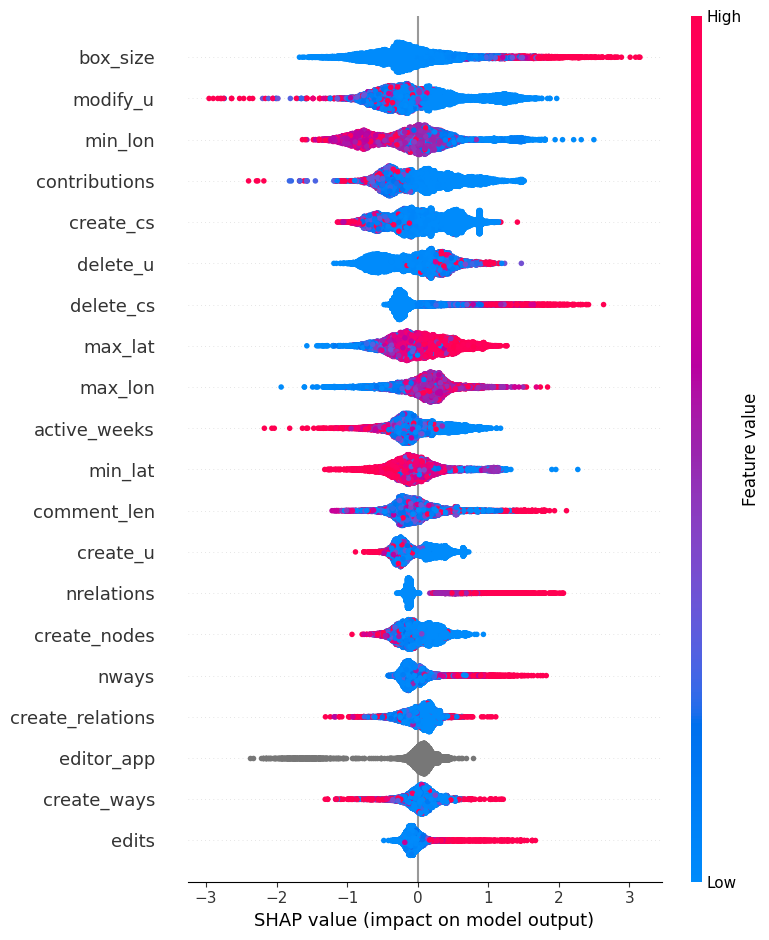

In [19]:
explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(X_test_cb)
shap.summary_plot(shap_values, X_test_cb)

324/324 [==============================] - 1s 2ms/step
######################## TRAINING DATA ###########################
              precision    recall  f1-score   support

       False       0.80      0.83      0.82     18841
        True       0.81      0.78      0.79     17436

    accuracy                           0.81     36277
   macro avg       0.81      0.80      0.80     36277
weighted avg       0.81      0.81      0.81     36277

########################## TEST DATA #############################
              precision    recall  f1-score   support

       False       0.80      0.83      0.81      5382
        True       0.81      0.78      0.79      4983

    accuracy                           0.80     10365
   macro avg       0.80      0.80      0.80     10365
weighted avg       0.80      0.80      0.80     10365



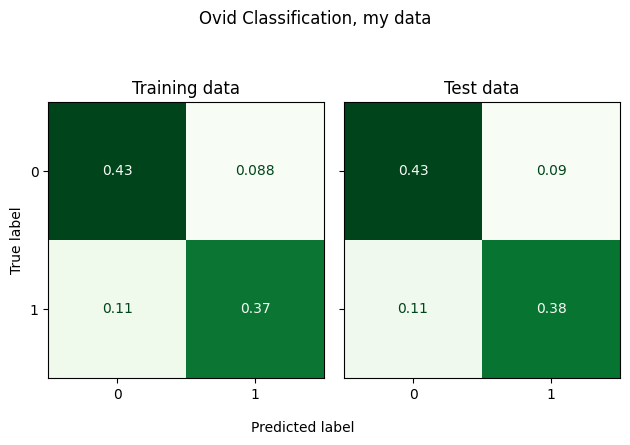

In [57]:
original_data = False
my_data = True

# the original model was trained with random_state = 42, so the same will be used below for reproducibility

no_changeset_features = 20 if original_data else 21
ovid = TweakedOvid.Ovid(no_changeset_features=no_changeset_features)

features_df = pd.read_csv('/Users/dansvenonius/PycharmProjects/MastersThesis/Dataset/ovid_data.csv').set_index("cs_id")
if original_data:
    ovid.load("/Users/dansvenonius/PycharmProjects/MastersThesis/models/ovid_model_original_data")
    features_df.drop(columns=['nprev_changesets', 'imagery_used'], inplace=True)
    title = "Ovid Classification, original data"
elif my_data:
    ovid.load("/Users/dansvenonius/PycharmProjects/MastersThesis/models/ovid_model_my_data")
    features_df.drop(columns='acc_created', inplace=True)
    title = "Ovid Classification, my data"

labels_features = labels.join(features_df, how="left").reset_index()
labels_features.fillna(0, inplace=True)

y_ovid = labels_features["label"].to_numpy()
X_ovid = labels_features.drop(["label", "cs_id"], axis='columns').to_numpy()

# 20% test
X_train_ovid, X_test_ovid, y_train_ovid, y_test_ovid = train_test_split(X_ovid, y_ovid, test_size=0.2, random_state=random_state)

# 10% validation, 70% train
X_train_ovid, X_val_ovid, y_train_ovid, y_val_ovid = train_test_split(X_train_ovid, y_train_ovid, test_size=0.125, random_state=random_state)
ovid.fit_scaler(X_train_ovid)

ovid_pred_train = ovid.predict(X_train_ovid)
ovid_pred_test = ovid.predict(X_test_ovid)

hf.print_report(ovid_pred_train, y_train_ovid, ovid_pred_test, y_test_ovid, title=title)

In [ ]:
hf.tSNEplot(labels, csdf=csdf, udf=udf)

In [ ]:
# INTRODUCING A THREE CLASSES: FULLY/PARTIALLY/NOT REVERTED
multi_file = 'multi_labels_part.csv'
target_names = ['full', 'partial', 'non']

In [ ]:
X, y = hf.get_prepped_csudf(dataset_path, multi_label=True, multi_file=multi_file, to_numpy=False)
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy().argmax(axis=1), test_size=0.2, random_state=random_state)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred_train, pred_test = rfc.predict(X_train), rfc.predict(X_test)
hf.print_report(pred_train, y_train, pred_test, y_test, target_names, title="Random Forest, unbalanced dataset", normalize=False)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)
cb_model = CatBoostClassifier(iterations=10000, eval_metric='TotalF1')
cb_model.fit(X_train, y_train, early_stopping_rounds=1500, eval_set=[(X_val, y_val)], plot=True)
pred_train, pred_test = cb_model.predict(X_train), cb_model.predict(X_test)
hf.print_report(pred_train, y_train, pred_test, y_test, target_names, title="Catboost, unbalanced dataset", normalize=False)

In [ ]:
n_samples = np.where(y['partial_revert'] == True, 1, 0).sum()
X_full = X.loc[y['full_revert'], :].sample(n_samples)
X_non = X.loc[y['non_revert'], :].sample(n_samples)
X_rev = X.loc[y['partial_revert'], :].sample(n_samples)

X = pd.concat([X_full, X_rev, X_non]).join(y)
y = X.loc[:, ['full_revert', 'partial_revert', 'non_revert']].to_numpy().argmax(axis=1)
X = X.drop(labels=['full_revert', 'partial_revert', 'non_revert'], axis=1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred_train, pred_test = rfc.predict(X_train), rfc.predict(X_test)
hf.print_report(pred_train, y_train, pred_test, y_test, target_names, title="Random Forest, balanced dataset", normalize=False)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)
cb_model = CatBoostClassifier(iterations=10000, eval_metric='TotalF1')
cb_model.fit(X_train, y_train, early_stopping_rounds=1500, eval_set=[(X_val, y_val)], plot=True)
pred_train, pred_test = cb_model.predict(X_train), cb_model.predict(X_test)
hf.print_report(pred_train, y_train, pred_test, y_test, target_names, title="Catboost, balanced dataset", normalize=False)

In [ ]:
c1, c2 = 'partial_revert', 'full_revert' # possible values: 'partial_revert', 'full_revert', 'non_revert'
X, y = hf.get_2_of_3_classes(dataset_path, 'partial_revert', 'non_revert', multi_file, to_numpy=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred_train, pred_test = rfc.predict(X_train), rfc.predict(X_test)
hf.print_report(pred_train, y_train, pred_test, y_test, [c2, c1], title=f'Random forest, {c1} and {c2}', normalize=False)

In [4]:
from sklearn.metrics import classification_report

threshold = 1 # quite reasonable that it'd be more than one active week. Cause that takes time into consideration in a way that nrepv_changesets doesnt
exp_metric = 'active_weeks'
# exp_metric = 'nprev_changesets'
labels = pd.read_csv(dataset_path + 'labels.csv').set_index('cs_id')

X, y = hf.get_prepped_csudf(dataset_path)
X['experienced'] = X[exp_metric] > threshold
exp_count = len(X.loc[X['experienced'] == True, :].index)
print(f'Inexperienced: {len(X.index) - exp_count}, experienced: {exp_count}')

X = X.to_numpy()
# exp_idx = np.where(X[:, -1] == True)[0]
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# The following hyperparameters come from a GridSearchCV.
hyperparameters = {
    'max_depth': 100,
    'max_features': 5,
    'n_estimators': 500
}
rfc = RandomForestClassifier(**hyperparameters)

rfc.fit(X_train[:, :-1], y_train.ravel())
rfc_pred_test = rfc.predict(X_test[:, :-1])
rfc_pred_train = rfc .predict(X_train[:, :-1])
hf.print_report(rfc_pred_train, y_train, rfc_pred_test, y_test, normalize=False)
rfc_experienced_test = rfc.predict(X_test[X_test[:, -1] == True, :-1])
rfc_inexperienced_test = rfc.predict(X_test[X_test[:, -1] == False, :-1])

print("################## EXPERIENCED USERS ##################")
print(classification_report(y_test[X_test[:, -1] == True], rfc_experienced_test))
print("################## INEXPERIENCED USERS ##################")
print(classification_report(y_test[X_test[:, -1] == False], rfc_inexperienced_test))

NameError: name 'path' is not defined

In [144]:
# Following a number of data points through the models:
from subprocess import call

id = 13544059
X, y, is_test = hf.get_by_id(dataset_path, id)
X_sample_cb = X_cb.loc[id, :]
X_sample_ovid, _, _ = hf.get_by_id(dataset_path, id, ovid_data=True, original_data=original_data)
X = np.reshape(X, (1, -1))
X_sample_ovid = np.reshape(X_sample_ovid, (1, -1))

mlp_pred = mlp.predict(scaler.transform(X))[0] == 1
rfc_pred = rfc_baseline.predict(X)[0] == 1
cb_pred = cb_model.predict(X_sample_cb)
ovid_pred = ovid.predict(X_sample_ovid)[0]

s1 = 'True = Reverted, False = Not Reverted\n'
s2 = f'In test data: {is_test}, \nGround truth: {y}, \nMLP: {mlp_pred}, \nRF: {rfc_pred}, \nCB: {cb_pred}, \nOvid: {ovid_pred}.'
# cmd = 'echo "%s" | pbcopy' % s2
# call([cmd], shell=True)
print(s1 + s2)

1/1 [==============================] - 0s 32ms/step
True = Reverted, False = Not Reverted
In test data: True, 
Ground truth: False, 
MLP: True, 
RF: False, 
CB: False, 
Ovid: False.


In [ ]:
# px.histogram(plot_csdf, x='create', log_y=True, color="split", barmode="overlay", histnorm="percent",
#              nbins=50, title="Changeset Data", width=600)